# Hands-on tutorial for DETR

In this notebook, we show-case how to:
* use the pre-trained models that we provide to make predictions
* visualize the attentions of the model to gain insights on the way it sees the images.

In [1]:
import os

import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

device = torch.device('cuda')

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

from detr_helper import (CLASSES, COLORS, transform, rescale_bboxes,
                         plot_results, get_attention_weights, to_numpy)

In [3]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [4]:
model.eval()

with torch.no_grad():
    model = model.to(device)

In [5]:
# retrieve the image as a PIL image
im = Image.open('000000039769.jpg')
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0).to(device)

In [6]:
# propagate through the model
outputs = model(img)

device_cpu = torch.device("cpu")
outputs = {k: v.to(device_cpu) for k, v in outputs.items()}

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

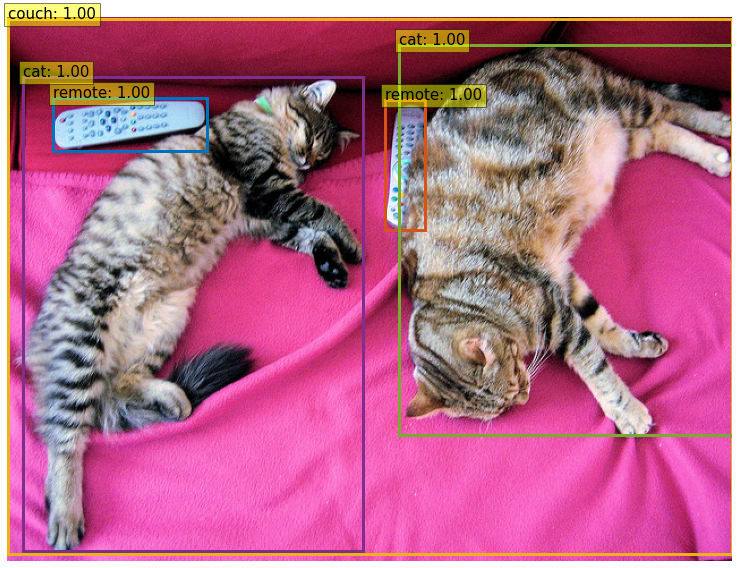

In [7]:
plot_results(im, probas[keep], bboxes_scaled)

# Detection - Visualize encoder-decoder multi-head attention weights

Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.

We will use hooks to extract attention weights (averaged over all heads) from the transformer.

In [8]:
conv_features, enc_attn_weights, dec_attn_weights = get_attention_weights(model, img)

Now let's visualize them

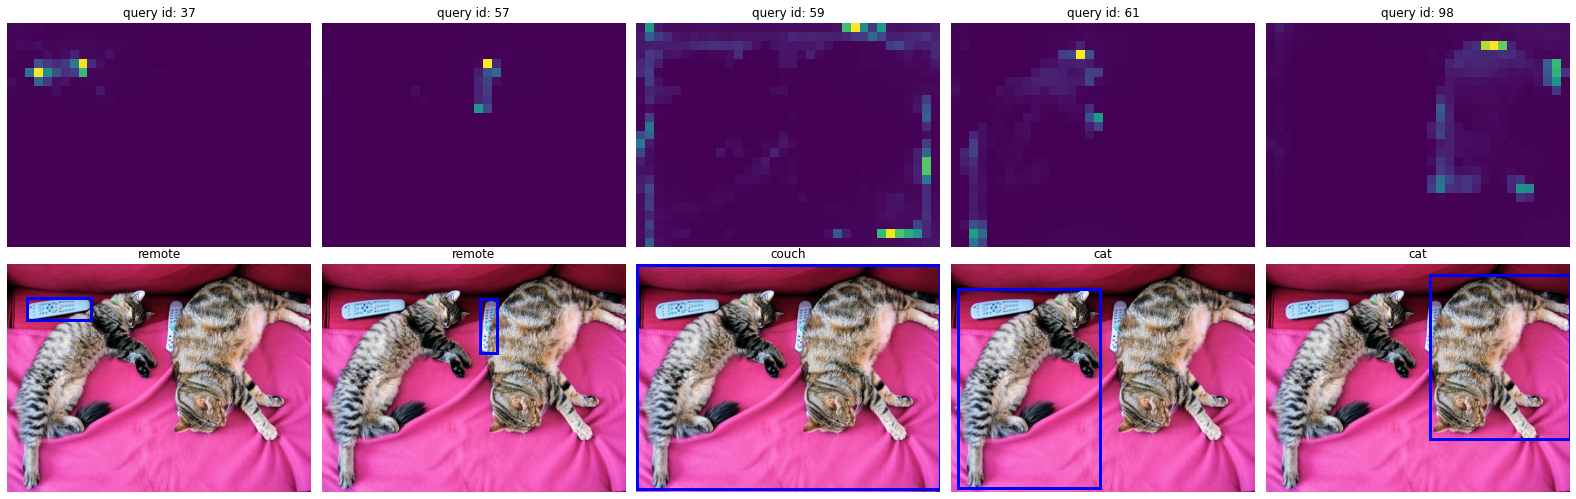

In [9]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(torch.where(keep)[0], axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(to_numpy(dec_attn_weights[0, idx].view(h, w)))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# Visualize encoder self-attention weights

In this section we visualize the model's self-attention. This allows us to gain intuition on how the model encodes the objects. In particular, we see from the attention response maps that the encoder already participate to the instance separation process.

Let's start by visualizing the shape of the encoder self-attention:

In [10]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([850, 850])
Feature map:             torch.Size([1, 2048, 25, 34])


As we can see, the self-attention is a square matrix of size `[H * W, H * W]`, where `H` and `W` are the sizes of the feature map, so we reshape it so that it has a more interpretable representation of `[H, W, H, W]`.

In [11]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 34, 25, 34])


Now that we have the self-attention into a more interpretable representation, let's try to visualize it.
Given that the self-attention is a very large matrix, let's start by selecting a few reference points where we will be looking at the attention.

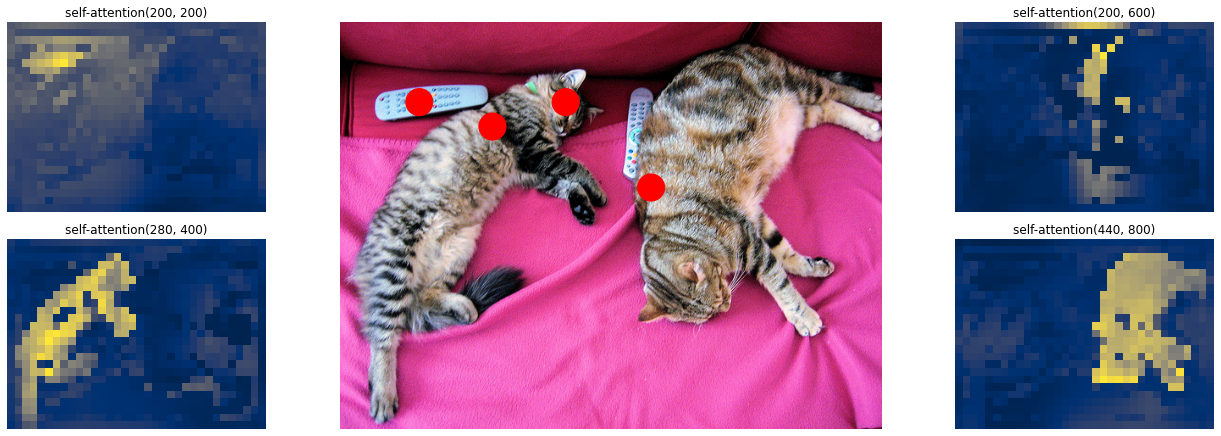

In [12]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(to_numpy(sattn[..., idx[0], idx[1]]), cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-1]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

That's pretty nice! This visualization gives the intuition that the encoder might be already performing some sort of object separation thanks to the self-attention mechanism.